In [ ]:
import sys
import optparse
import time
import sys
from transformers import BertForSequenceClassification, BertTokenizer
import nltk
import os
import feedparser
import requests


/Users/admin/Projects/CDS-project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
csv_file = "./sentences_sentiment1.csv"

df = pd.read_csv(csv_file)

len(df)

50918

In [3]:
df["date"] = pd.to_datetime(df["date"], errors='coerce')  # Convert to datetime, ignore errors

print("Earliest date:", df["date"].min())
print("Latest date:", df["date"].max())

Earliest date: 2023-07-12 10:27:37+00:00
Latest date: 2025-04-11 10:41:54+00:00


remove timestamps

In [4]:
import re

def remove_all_timestamps(text):
    return re.sub(r"\[[^\]]*\]", "", text).strip()


df["sentence"] = df["sentence"].apply(remove_all_timestamps)

Extract date in eastern time

In [5]:
# Convert to datetime and localize
df["datetime"] = pd.to_datetime(df["date"], utc=True)
df["datetime_et"] = df["datetime"].dt.tz_convert("America/New_York")
# Extract date part only (in Eastern Time)
df["market_day"] = df["datetime_et"].dt.date


logit into proper list

In [6]:
import re
import ast

def fix_and_parse_logit(logit_str):
    if isinstance(logit_str, str):
        # Insert commas between numbers using regex
        logit_str = re.sub(r'(?<=\d) (?=\d)', ',', logit_str.strip())
        try:
            return ast.literal_eval(logit_str)
        except:
            return [0.0, 0.0, 0.0]  # fallback if still broken
    return logit_str  # already a list

df["logit"] = df["logit"].apply(fix_and_parse_logit)


In [7]:
import re

# 1. Expanded keyword lists with more granular categorization
# Direct NVIDIA references
nvidia_direct_keywords = [
    "nvidia", "nvda", "jensen huang", "jensen wang", "blackwell", "hopper", "ampere", "ada lovelace",
    "cuda", "tensor cores", "cuda cores", "nvlink", "mellanox", "geforce", "rtx", "gtx",
    "dgx", "drive", "jetson", "turing", "shield", "omniverse"
]

# Related technology terms
tech_keywords = [
    "gpu", "accelerator", "chip", "semiconductor", "semiconductors", "chipset",
    "graphics card", "data center", "datacenter", "high performance computing", "hpc",
    "parallel computing", "inference", "training", "ray tracing", "dlss"
]

# AI and computing ecosystem
ai_ecosystem_keywords = [
    "ai", "artificial intelligence", "machine learning", "deep learning", "neural network",
    "generative ai", "llm", "large language model", "transformer", "diffusion model",
    "computer vision", "accelerated computing", "supercomputing", "ai inference"
]

# Key partners and competitors
partners_competitors_keywords = [
    "tsmc", "intel", "amd", "arm", "google", "microsoft", "amazon", "aws", "azure",
    "meta", "openai", "oracle", "ibm", "dell", "hp", "supermicro", "qualcomm", "broadcom",
    "apple", "samsung", "hyperscaler"
]

# Market conditions and macroeconomic factors
market_keywords = [
    "nasdaq", "semiconductor index", "philadelphia semiconductor", "sox", "chip stocks",
    "tech stocks", "fed", "fomc", "interest rate", "inflation", "gdp", "recession",
    "market selloff", "rally", "bear market", "bull market", "market crash"
]

# Geopolitical and supply chain risks
risk_keywords = [
    "china", "taiwan", "export control", "sanctions", "tariff", "trade war", "chip act",
    "regulation", "antitrust", "supply chain", "chip shortage", "inventory", "allocation",
    "wafer", "foundry", "fab", "downturn", "headwind", "competitive pressure"
]

# Sentiment and analyst terms
sentiment_keywords = [
    "upgrade", "downgrade", "price target", "buy rating", "sell rating", "outperform",
    "underperform", "overweight", "underweight", "bullish", "bearish", "guidance",
    "forecast", "outlook", "revenue growth", "margin", "valuation", "multiple"
]

# 2. Combine all keywords into master lists but maintain separate categories for analysis
all_nvidia_keywords = nvidia_direct_keywords + tech_keywords + ai_ecosystem_keywords + partners_competitors_keywords
all_macro_keywords = market_keywords + risk_keywords + sentiment_keywords

# 3. Create pattern for regex matching with word boundaries
nvidia_pattern = r"\b(" + "|".join(re.escape(k) for k in all_nvidia_keywords) + r")\b"
macro_pattern = r"\b(" + "|".join(re.escape(k) for k in all_macro_keywords) + r")\b"

# 4. Create more granular flags for better filtering and analysis
def categorize_sentence(row):
    sentence = row["sentence"].lower()
    
    # Create flags for each category
    has_direct_nvidia = any(term in sentence for term in nvidia_direct_keywords)
    has_tech = any(term in sentence for term in tech_keywords)
    has_ai = any(term in sentence for term in ai_ecosystem_keywords)
    has_partner_competitor = any(term in sentence for term in partners_competitors_keywords)
    has_market = any(term in sentence for term in market_keywords)
    has_risk = any(term in sentence for term in risk_keywords)
    has_sentiment = any(term in sentence for term in sentiment_keywords)
    
    # Combined flags
    has_any_nvidia = has_direct_nvidia or has_tech or has_ai or has_partner_competitor
    has_any_macro = has_market or has_risk or has_sentiment
    
    # Relevance score (higher = more relevant to NVIDIA)
    relevance_score = (has_direct_nvidia * 3) + (has_tech * 2) + (has_ai * 2) + \
                      (has_partner_competitor * 1) + (has_market * 0.5) + \
                      (has_risk * 1) + (has_sentiment * 0.5)
    
    return {
        "has_direct_nvidia": has_direct_nvidia,
        "has_tech": has_tech,
        "has_ai": has_ai,
        "has_partner_competitor": has_partner_competitor,
        "has_market": has_market,
        "has_risk": has_risk,
        "has_sentiment": has_sentiment,
        "has_any_nvidia": has_any_nvidia,
        "has_any_macro": has_any_macro,
        "relevance_score": relevance_score
    }

# 5. Apply the categorization function
categorized = df.apply(categorize_sentence, axis=1)

# 6. Add new columns to dataframe
for key in categorized.iloc[0].keys():
    df[key] = categorized.apply(lambda x: x[key])

# 7. Create filtered dataframes with different relevance thresholds
# Primary NVIDIA relevant dataframe (includes direct mentions and strong indirect relevance)
df_nvda_relevant = df[(df["has_direct_nvidia"]) | 
                      (df["has_tech"] & df["has_ai"]) | 
                      ((df["has_partner_competitor"] | df["has_risk"]) & df["relevance_score"] >= 2)].copy()

# Secondary macro risk dataframe (more general market conditions that might affect NVIDIA)
df_macro_risk = df[(df["has_any_macro"]) & (df["relevance_score"] < 2)].copy()

# Highly relevant NVIDIA dataframe (most focused)
df_nvda_core = df[df["relevance_score"] >= 3].copy()

print(f"Total rows: {len(df)}")
print(f"NVIDIA relevant rows: {len(df_nvda_relevant)} ({len(df_nvda_relevant)/len(df):.1%})")
print(f"Macro risk rows: {len(df_macro_risk)} ({len(df_macro_risk)/len(df):.1%})")
print(f"NVIDIA core rows: {len(df_nvda_core)} ({len(df_nvda_core)/len(df):.1%})")

Total rows: 50918
NVIDIA relevant rows: 1865 (3.7%)
Macro risk rows: 5952 (11.7%)
NVIDIA core rows: 3773 (7.4%)


In [8]:
def enhance_nvidia_sentiment(row):
    """
    Enhance sentiment analysis specifically for NVIDIA using category-aware rules
    """
    # Get original sentiment values
    orig_logit = row['logit'] if isinstance(row['logit'], list) else [0.33, 0.33, 0.34]
    orig_sentiment_score = row['sentiment_score']
    orig_prediction = row['prediction']
    
    # Initialize enhanced values
    enhanced_logit = orig_logit.copy()
    enhanced_score = orig_sentiment_score
    enhanced_prediction = orig_prediction
    
    # Extract text and lowercase for analysis
    sentence = row['sentence'].lower()
    
    # Factor weights (adjust these based on performance)
    direct_nvidia_weight = 1.0
    competitor_weight = 0.8
    china_weight = 0.7
    tech_weight = 0.6
    market_weight = 0.5
    
    # Track applied rules for explanation
    applied_rules = []
    
    # ------------------------
    # Rule 1: Direct NVIDIA mentions (strongest factor)
    # ------------------------
    if row["has_direct_nvidia"]:
        # Direct mentions - enhance existing sentiment direction
        if orig_prediction == 'positive' or orig_sentiment_score > 0.2:
            enhanced_logit[0] = min(1.0, enhanced_logit[0] * (1 + 0.3 * direct_nvidia_weight))
            enhanced_logit[1] = max(0.0, enhanced_logit[1] * (1 - 0.3 * direct_nvidia_weight))
            enhanced_score = min(1.0, enhanced_score + 0.2 * direct_nvidia_weight)
            applied_rules.append("Direct NVIDIA positive enhancement")
            
        elif orig_prediction == 'negative' or orig_sentiment_score < -0.2:
            enhanced_logit[1] = min(1.0, enhanced_logit[1] * (1 + 0.3 * direct_nvidia_weight))
            enhanced_logit[0] = max(0.0, enhanced_logit[0] * (1 - 0.3 * direct_nvidia_weight))
            enhanced_score = max(-1.0, enhanced_score - 0.2 * direct_nvidia_weight)
            applied_rules.append("Direct NVIDIA negative enhancement")
    
    # ------------------------
    # Rule 2: Competitor analysis (important factor)
    # ------------------------
    if row["has_partner_competitor"]:
        # Check for competitors with contextual sentiment
        competitors = ["intel", "amd", "qualcomm"]
        if any(comp in sentence for comp in competitors):
            # Competitor sentiment inversion (their bad news is good for NVIDIA)
            if any(neg_term in sentence for neg_term in ["struggle", "decline", "missed", "layoff", "delay", 
                                                        "down", "fall", "weak", "problem", "issue", "challenge",
                                                        "bad news", "setback", "behind", "lost"]):
                enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3 * competitor_weight)
                enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.3 * competitor_weight)
                enhanced_score = min(1.0, abs(orig_sentiment_score) * 0.7 + 0.3)  # Invert and boost
                enhanced_prediction = 'positive'
                applied_rules.append("Competitor negative → NVIDIA positive")
                
            elif any(pos_term in sentence for pos_term in ["gain", "advance", "beat", "success", "lead", 
                                                          "positive", "growth", "strong", "ahead", "win"]):
                enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3 * competitor_weight)
                enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * competitor_weight)
                enhanced_score = max(-1.0, -abs(orig_sentiment_score) * 0.7 - 0.3)  # Invert and make negative
                enhanced_prediction = 'negative'
                applied_rules.append("Competitor positive → NVIDIA negative")
        
        # Check for partners with contextual sentiment
        partners = ["tsmc", "microsoft", "amazon", "google", "openai", "meta"]
        if any(partner in sentence for partner in partners):
            # Partner sentiment alignment (their good news is good for NVIDIA)
            if orig_prediction == 'positive' or orig_sentiment_score > 0.1:
                enhanced_logit[0] = min(1.0, enhanced_logit[0] * (1 + 0.2 * competitor_weight))
                enhanced_score = min(1.0, enhanced_score + 0.15 * competitor_weight)
                applied_rules.append("Partner positive → NVIDIA positive")
                
            elif orig_prediction == 'negative' or orig_sentiment_score < -0.1:
                enhanced_logit[1] = min(1.0, enhanced_logit[1] * (1 + 0.2 * competitor_weight))
                enhanced_score = max(-1.0, enhanced_score - 0.15 * competitor_weight)
                applied_rules.append("Partner negative → NVIDIA negative")
    
    # ------------------------
    # Rule 3: China & geopolitical risk
    # ------------------------
    if "china" in sentence or "taiwan" in sentence or "export control" in sentence:
        # China restrictions or export controls are negative for NVIDIA
        if any(restriction in sentence for restriction in ["restriction", "ban", "control", "limit", 
                                                         "regulation", "tariff", "sanction"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4 * china_weight)
            enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * china_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.35 * china_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("China restrictions → NVIDIA negative")
            
        # China market growth is positive
        elif any(growth in sentence for growth in ["growth", "expand", "invest", "surge", "soar", "demand"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.35 * china_weight)
            enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.25 * china_weight)
            enhanced_score = min(1.0, enhanced_score + 0.3 * china_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("China growth → NVIDIA positive")
    
    # ------------------------
    # Rule 4: AI and tech market conditions
    # ------------------------
    if row["has_ai"] and row["has_tech"]:
        # AI + Tech co-occurrence is especially relevant to NVIDIA
        if orig_prediction == 'positive' or orig_sentiment_score > 0:
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.4 * tech_weight)
            enhanced_logit[1] = max(0.0, enhanced_logit[1] - 0.3 * tech_weight)
            enhanced_score = min(1.0, enhanced_score + 0.3 * tech_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("AI+Tech positive → NVIDIA strongly positive")
            
        elif orig_prediction == 'negative' or orig_sentiment_score < 0:
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4 * tech_weight)
            enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3 * tech_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.3 * tech_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("AI+Tech negative → NVIDIA strongly negative")
    
    # ------------------------
    # Rule 5: General market conditions
    # ------------------------
    if row["has_market"]:
        # Interest rates, Fed decisions impact high-growth tech like NVIDIA
        if any(term in sentence for term in ["interest rate", "fed", "inflation", "fomc"]):
            if any(neg in sentence for neg in ["hike", "raise", "higher", "increase", "hawkish"]):
                enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.25 * market_weight)
                enhanced_score = max(-1.0, enhanced_score - 0.2 * market_weight)
                if enhanced_score < -0.3:  # Only change prediction if strongly negative
                    enhanced_prediction = 'negative'
                applied_rules.append("Rate hikes → NVIDIA negative")
                
            elif any(pos in sentence for pos in ["cut", "lower", "decrease", "dovish", "pause"]):
                enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.25 * market_weight)
                enhanced_score = min(1.0, enhanced_score + 0.2 * market_weight)
                if enhanced_score > 0.3:  # Only change prediction if strongly positive
                    enhanced_prediction = 'positive'
                applied_rules.append("Rate cuts → NVIDIA positive")
        
        # Market sentiment impacts high-beta stocks like NVIDIA more
        if any(crash in sentence for crash in ["crash", "tumbl", "plummet", "bear market", "sell-off"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3 * market_weight)
            enhanced_score = max(-1.0, enhanced_score - 0.25 * market_weight)
            enhanced_prediction = 'negative'
            applied_rules.append("Market crash → NVIDIA strongly negative")
            
        elif any(rally in sentence for rally in ["rally", "bull market", "surge", "soar"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3 * market_weight)
            enhanced_score = min(1.0, enhanced_score + 0.25 * market_weight)
            enhanced_prediction = 'positive'
            applied_rules.append("Market rally → NVIDIA strongly positive")
    
    # ------------------------
    # Rule 6: Supply chain and manufacturing
    # ------------------------
    if any(supply in sentence for supply in ["shortage", "supply chain", "inventory", "wafer", "foundry"]):
        if any(neg in sentence for neg in ["constraint", "issue", "problem", "challenge", "delay"]):
            enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.3)
            enhanced_score = max(-1.0, enhanced_score - 0.25)
            enhanced_prediction = 'negative'
            applied_rules.append("Supply chain issues → NVIDIA negative")
            
        elif any(pos in sentence for pos in ["improv", "resolv", "better", "easing"]):
            enhanced_logit[0] = min(1.0, enhanced_logit[0] + 0.3)
            enhanced_score = min(1.0, enhanced_score + 0.25)
            enhanced_prediction = 'positive'
            applied_rules.append("Supply chain improvement → NVIDIA positive")
    
    # ------------------------
    # Rule 7: Tariffs are particularly negative for semiconductor companies
    # ------------------------
    if "tariff" in sentence or "trade war" in sentence:
        enhanced_logit[1] = min(1.0, enhanced_logit[1] + 0.4)
        enhanced_logit[0] = max(0.0, enhanced_logit[0] - 0.3)
        enhanced_score = max(-1.0, enhanced_score - 0.35)
        enhanced_prediction = 'negative'
        applied_rules.append("Tariffs → NVIDIA strongly negative")
    
    # Normalize logits to sum to 1
    # --- Normalize logits safely ---
    logit_sum = sum(enhanced_logit)
    if logit_sum > 0:
        enhanced_logit = [x / logit_sum for x in enhanced_logit]
    else:
        enhanced_logit = [1/3, 1/3, 1/3]
        applied_rules.append("Logit normalization fallback to neutral")

    
    # Return enhanced values and explanation
    return {
        'nvda_enhanced_logit': enhanced_logit,
        'nvda_enhanced_score': enhanced_score,
        'nvda_enhanced_prediction': enhanced_prediction,
        'applied_rules': "; ".join(applied_rules) if applied_rules else "No specific rules applied"
    }

In [9]:
# Apply the enhancement function to your filtered dataframe
enhancements = df_nvda_relevant.apply(enhance_nvidia_sentiment, axis=1)

# Add the enhanced columns to your dataframe
df_nvda_relevant['nvda_enhanced_logit'] = enhancements.apply(lambda x: x['nvda_enhanced_logit'])
df_nvda_relevant['nvda_enhanced_score'] = enhancements.apply(lambda x: x['nvda_enhanced_score'])
df_nvda_relevant['nvda_enhanced_prediction'] = enhancements.apply(lambda x: x['nvda_enhanced_prediction'])
df_nvda_relevant['enhancement_explanation'] = enhancements.apply(lambda x: x['applied_rules'])


# Apply enhancements to the other filtered datasets
df_nvda_core_enhanced = df_nvda_core.copy()
df_macro_risk_enhanced = df_macro_risk.copy()

# Apply enhancement to NVIDIA core dataset
core_enhancements = df_nvda_core.apply(enhance_nvidia_sentiment, axis=1)
for key in ['nvda_enhanced_logit', 'nvda_enhanced_score', 'nvda_enhanced_prediction', 'applied_rules']:
    df_nvda_core_enhanced[key if key != 'applied_rules' else 'enhancement_explanation'] = core_enhancements.apply(lambda x: x[key])

# Apply enhancement to macro risk dataset - you might want to adjust weights in the function
macro_enhancements = df_macro_risk.apply(enhance_nvidia_sentiment, axis=1)
for key in ['nvda_enhanced_logit', 'nvda_enhanced_score', 'nvda_enhanced_prediction', 'applied_rules']:
    df_macro_risk_enhanced[key if key != 'applied_rules' else 'enhancement_explanation'] = macro_enhancements.apply(lambda x: x[key])

# Add a source column to track which dataset each row came from
df_nvda_relevant['source'] = 'nvidia_relevant'
df_nvda_core_enhanced['source'] = 'nvidia_core'
df_macro_risk_enhanced['source'] = 'macro_risk'

# Combine all datasets
# Note: Be careful of duplicates since df_nvda_core likely overlaps with df_nvda_relevant
# First, get unique IDs from each dataset to avoid duplicates
relevant_ids = set(df_nvda_relevant.index)
core_ids = set(df_nvda_core_enhanced.index)
macro_ids = set(df_macro_risk_enhanced.index)

# Filter out duplicates from core dataset that are already in relevant dataset
unique_core_ids = core_ids - relevant_ids
df_nvda_core_unique = df_nvda_core_enhanced.loc[list(unique_core_ids)]

# Filter out duplicates from macro dataset that are in either relevant or core
unique_macro_ids = macro_ids - relevant_ids - core_ids
df_macro_risk_unique = df_macro_risk_enhanced.loc[list(unique_macro_ids)]

# Combine the filtered datasets
df_combined = pd.concat([df_nvda_relevant, df_nvda_core_unique, df_macro_risk_unique])

print(f"Combined dataset size: {len(df_combined)} rows")

Combined dataset size: 9725 rows


In [10]:
# Calculate changes in sentiment prediction for the combined dataset
combined_sentiment_shift = (df_combined['prediction'] != df_combined['nvda_enhanced_prediction']).mean()
combined_positive_shift = ((df_combined['prediction'] != 'positive') & 
                          (df_combined['nvda_enhanced_prediction'] == 'positive')).sum()
combined_negative_shift = ((df_combined['prediction'] != 'negative') & 
                          (df_combined['nvda_enhanced_prediction'] == 'negative')).sum()

print(f"COMBINED DATASET ANALYSIS:")
print(f"Sentiment prediction changed in {combined_sentiment_shift:.2%} of rows")
print(f"Sentences shifted to positive: {combined_positive_shift}")
print(f"Sentences shifted to negative: {combined_negative_shift}")

# Analyze which rules were most frequently applied across the combined dataset
combined_rule_analysis = df_combined['enhancement_explanation'].str.split(';').explode().str.strip()
combined_top_rules = combined_rule_analysis.value_counts().head(10)
print("\nTop 10 applied rules in combined dataset:")
print(combined_top_rules)

# Additionally, analyze rule application by source dataset
print("\nRule application breakdown by dataset source:")
for source in df_combined['source'].unique():
    source_data = df_combined[df_combined['source'] == source]
    source_rules = source_data['enhancement_explanation'].str.split(';').explode().str.strip()
    source_top_rules = source_rules.value_counts().head(5)
    
    source_sentiment_shift = (source_data['prediction'] != source_data['nvda_enhanced_prediction']).mean()
    source_positive_shift = ((source_data['prediction'] != 'positive') & 
                            (source_data['nvda_enhanced_prediction'] == 'positive')).sum()
    source_negative_shift = ((source_data['prediction'] != 'negative') & 
                            (source_data['nvda_enhanced_prediction'] == 'negative')).sum()
    
    print(f"\n--- {source} dataset analysis ---")
    print(f"Sentiment prediction changed in {source_sentiment_shift:.2%} of rows")
    print(f"Sentences shifted to positive: {source_positive_shift}")
    print(f"Sentences shifted to negative: {source_negative_shift}")
    print(f"Top 5 rules:")
    print(source_top_rules)

COMBINED DATASET ANALYSIS:
Sentiment prediction changed in 9.51% of rows
Sentences shifted to positive: 423
Sentences shifted to negative: 502

Top 10 applied rules in combined dataset:
enhancement_explanation
Logit normalization fallback to neutral        3549
No specific rules applied                      3497
Direct NVIDIA positive enhancement              622
Tariffs → NVIDIA strongly negative              500
Direct NVIDIA negative enhancement              417
Rate cuts → NVIDIA positive                     398
Partner positive → NVIDIA positive              353
Market rally → NVIDIA strongly positive         322
AI+Tech positive → NVIDIA strongly positive     289
Rate hikes → NVIDIA negative                    227
Name: count, dtype: int64

Rule application breakdown by dataset source:

--- nvidia_relevant dataset analysis ---
Sentiment prediction changed in 13.35% of rows
Sentences shifted to positive: 164
Sentences shifted to negative: 85
Top 5 rules:
enhancement_explanation
Lo

In [11]:
df_combined.head()

,sentence,title,date,sentiment_score,logit,prediction,datetime,datetime_et,market_day,has_direct_nvidia,...,has_risk,has_sentiment,has_any_nvidia,has_any_macro,relevance_score,nvda_enhanced_logit,nvda_enhanced_score,nvda_enhanced_prediction,enhancement_explanation,source
52,The services PMI came in at 54.3 versus 51.2 c...,Households_face_$3_trillion_in_lost_stock_weal...,2025-03-24 15:55:23+00:00,0.044800,"[0.49484387, 0.45004404, 0.05511211]",positive,2025-03-24 15:55:23+00:00,2025-03-24 11:55:23-04:00,2025-03-24,True,...,False,False,True,False,3.0,"[0.6347657983479434, 0.31085297367031317, 0.05...",0.244800,positive,Direct NVIDIA positive enhancement,nvidia_relevant
70,The coffee store chain was said to be hinting ...,Households_face_$3_trillion_in_lost_stock_weal...,2025-03-24 15:55:23+00:00,0.918196,"[0.94090825, 0.02271272, 0.03637904]",positive,2025-03-24 15:55:23+00:00,2025-03-24 11:55:23-04:00,2025-03-24,True,...,False,True,True,True,6.5,"[0.9503192627973586, 0.015109034728565974, 0.0...",1.000000,positive,Direct NVIDIA positive enhancement,nvidia_relevant
75,"Overall, F-150 sales have faced challenges, in...",Households_face_$3_trillion_in_lost_stock_weal...,2025-03-24 15:55:23+00:00,-0.929477,"[0.0, 0.0, 0.0]",negative,2025-03-24 15:55:23+00:00,2025-03-24 11:55:23-04:00,2025-03-24,True,...,False,False,True,False,3.0,"[0.3333333333333333, 0.3333333333333333, 0.333...",-1.000000,negative,Direct NVIDIA negative enhancement; Logit norm...,nvidia_relevant
86,"Amazon's Prime Day event, which has already st...",Amazon_Prime_Day_set_to_break_records,2024-07-16 10:47:44+00:00,0.190549,"[0.21043856, 0.01989001, 0.76967144]",neutral,2024-07-16 10:47:44+00:00,2024-07-16 06:47:44-04:00,2024-07-16,True,...,False,False,True,False,4.0,"[0.23615727184319366, 0.01924212422157409, 0.7...",0.310549,neutral,Partner positive → NVIDIA positive,nvidia_relevant
87,Adobe expects the first day to drive $7.1 bill...,Amazon_Prime_Day_set_to_break_records,2024-07-16 10:47:44+00:00,0.933596,"[0.0, 0.0, 0.0]",positive,2024-07-16 10:47:44+00:00,2024-07-16 06:47:44-04:00,2024-07-16,True,...,False,False,True,False,3.0,"[0.3333333333333333, 0.3333333333333333, 0.333...",1.000000,positive,Direct NVIDIA positive enhancement; Logit norm...,nvidia_relevant


In [12]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming df_combined has columns: 'date', 'nvda_enhanced_logit', 'sentence', etc.
# First make sure your date column is in datetime format
df_combined['date'] = pd.to_datetime(df_combined['date'])

# Extract just the date portion (without time) if needed
df_combined['market_day'] = df_combined['date'].dt.date

# Function to aggregate logits (stored as lists)
def aggregate_logits(logit_series):
    # Convert each logit list to numpy array for easier manipulation
    logit_arrays = [np.array(logit) for logit in logit_series if isinstance(logit, list)]
    
    # Check if we have valid logits to aggregate
    if not logit_arrays:
        return [0.33, 0.33, 0.34]  # Default neutral logit if no valid data
    
    # Calculate the mean of all logits for each position
    avg_logit = np.mean(logit_arrays, axis=0)
    
    # Return as a list
    return avg_logit.tolist()

# Function to calculate sentiment score from logits
def calculate_sentiment_score(logit):
    # Assuming logit format: [positive, negative, neutral]
    if not isinstance(logit, list) or len(logit) < 3:
        return 0  # Return neutral if invalid logit
    
    # Calculate sentiment score: positive weight - negative weight
    # This gives a value between -1 and 1
    return logit[0] - logit[1]

# Function to determine prediction from logits
def determine_prediction(logit):
    # Assuming logit format: [positive, negative, neutral]
    if not isinstance(logit, list) or len(logit) < 3:
        return 'neutral'  # Return neutral if invalid logit
    
    # Find the index of the maximum value
    max_index = np.argmax(logit)
    
    if max_index == 0:
        return 'positive'
    elif max_index == 1:
        return 'negative'
    else:
        return 'neutral'

# Group by market day and aggregate
market_day_data = []

for day, group in df_combined.groupby('market_day'):
    # Calculate average enhanced logits for the day
    avg_enhanced_logit = aggregate_logits(group['nvda_enhanced_logit'])
    
    # Calculate original average logits if available
    avg_original_logit = aggregate_logits(group['logit']) if 'logit' in group.columns else [0.33, 0.33, 0.34]
    
    # Count records and mentions
    record_count = len(group)
    nvidia_direct_mentions = group['has_direct_nvidia'].sum() if 'has_direct_nvidia' in group.columns else 0
    ai_mentions = group['has_ai'].sum() if 'has_ai' in group.columns else 0
    
    # Calculate sentiment scores
    enhanced_sentiment_score = calculate_sentiment_score(avg_enhanced_logit)
    original_sentiment_score = calculate_sentiment_score(avg_original_logit)
    
    # Determine predictions
    enhanced_prediction = determine_prediction(avg_enhanced_logit)
    original_prediction = determine_prediction(avg_original_logit)
    
    # Sample of sentences from the day (optional)
    sample_sentences = group['sentence'].sample(min(3, len(group))).tolist() if 'sentence' in group.columns else []
    
    # Add to results
    market_day_data.append({
        'market_day': day,
        'record_count': record_count,
        'nvidia_direct_mentions': nvidia_direct_mentions,
        'ai_mentions': ai_mentions,
        'avg_original_logit': avg_original_logit,
        'avg_enhanced_logit': avg_enhanced_logit,
        'original_sentiment_score': original_sentiment_score,
        'enhanced_sentiment_score': enhanced_sentiment_score,
        'original_prediction': original_prediction,
        'enhanced_prediction': enhanced_prediction,
        'sentiment_delta': enhanced_sentiment_score - original_sentiment_score,
        'sample_sentences': sample_sentences
    })

# Create a new dataframe with market day information
df_market_days = pd.DataFrame(market_day_data)

# Sort by date
df_market_days = df_market_days.sort_values('market_day')

# Display the result
print(f"Created market day dataframe with {len(df_market_days)} days")
print(df_market_days[['market_day', 'record_count', 'original_prediction', 
                     'enhanced_prediction', 'sentiment_delta']].head())

# Calculate overall prediction changes
prediction_changes = (df_market_days['original_prediction'] != df_market_days['enhanced_prediction']).mean()
positive_days_original = (df_market_days['original_prediction'] == 'positive').sum()
positive_days_enhanced = (df_market_days['enhanced_prediction'] == 'positive').sum()
negative_days_original = (df_market_days['original_prediction'] == 'negative').sum()
negative_days_enhanced = (df_market_days['enhanced_prediction'] == 'negative').sum()

print(f"\nDaily prediction summary:")
print(f"Days with changed prediction: {prediction_changes:.2%}")
print(f"Positive days (original): {positive_days_original} ({positive_days_original/len(df_market_days):.2%})")
print(f"Positive days (enhanced): {positive_days_enhanced} ({positive_days_enhanced/len(df_market_days):.2%})")
print(f"Negative days (original): {negative_days_original} ({negative_days_original/len(df_market_days):.2%})")
print(f"Negative days (enhanced): {negative_days_enhanced} ({negative_days_enhanced/len(df_market_days):.2%})")

Created market day dataframe with 550 days
   market_day  record_count original_prediction enhanced_prediction  \
0  2023-07-12            29             neutral            positive   
1  2023-07-13            31            negative            positive   
2  2023-07-14            16            negative            negative   
3  2023-07-15             4             neutral             neutral   
4  2023-07-16            12             neutral             neutral   

   sentiment_delta  
0         0.007230  
1         0.013099  
2        -0.034571  
3         0.250000  
4        -0.022381  

Daily prediction summary:
Days with changed prediction: 23.64%
Positive days (original): 50 (9.09%)
Positive days (enhanced): 109 (19.82%)
Negative days (original): 79 (14.36%)
Negative days (enhanced): 128 (23.27%)


In [13]:
pd.reset_option('display.max_colwidth')

df_market_days.head()

,market_day,record_count,nvidia_direct_mentions,ai_mentions,avg_original_logit,avg_enhanced_logit,original_sentiment_score,enhanced_sentiment_score,original_prediction,enhanced_prediction,sentiment_delta,sample_sentences
0,2023-07-12,29,2,4,"[0.10388673551724138, 0.10262935758620688, 0.2...","[0.3417563931413324, 0.33326892766250726, 0.32...",0.001257,0.008487,neutral,positive,0.007230,[The Dow is up 0.2% the S&P 500 is up 0.3% and...
1,2023-07-13,31,2,17,"[0.18700373387096772, 0.19754145774193546, 0.1...","[0.34719169484414875, 0.34463069821412134, 0.3...",-0.010538,0.002561,negative,positive,0.013099,"[The NASDAQ is up around 1%, the best performe..."
2,2023-07-14,16,0,2,"[0.06881164000000001, 0.11589727375, 0.0652910...","[0.3330200672977216, 0.41467682649902887, 0.25...",-0.047086,-0.081657,negative,negative,-0.034571,"[In other news of note,\n China's central ba..."
3,2023-07-15,4,1,3,"[0.047810899999999996, 0.0319686925, 0.4202203...","[0.3811442369842784, 0.11530202809003538, 0.50...",0.015842,0.265842,neutral,neutral,0.250000,"[For Tesla, of course, we're going to look at ..."
4,2023-07-16,12,2,2,"[0.07010478833333333, 0.051282214166666666, 0....","[0.12004142754621962, 0.12360028683129731, 0.7...",0.018823,-0.003559,neutral,neutral,-0.022381,[As for like the Fed and CPI and those kinds o...


In [17]:

print("Earliest date:", df_market_days["market_day"].min())
print("Latest date:", df_market_days["market_day"].max())

Earliest date: 2023-07-12
Latest date: 2025-04-11


In [14]:
%pip install tensorflow
%pip install --upgrade tensorflow
%pip install tensorflow-macos
%pip install tensorflow-metal  # for GPU acceleration



Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.19.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp39-cp39-macosx_10_9_universal2.whl.metadata (21 kB)
Using cached tensorflow-2.19.0-cp39-cp39-macosx_12_0_arm64.whl (252.5 MB)
Using cached ml_dtypes-0.5.1-cp39-cp39-macosx_10_9_universal2.whl (667 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalle

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Get NVIDIA price data from Yahoo Finance
nvda_price = yf.download('NVDA', start='2020-01-01', end='2025-04-20')
nvda_price = nvda_price.reset_index()
nvda_price['market_day'] = nvda_price['Date'].dt.date

# 2. Merge with your sentiment data
# Assuming df_market_days has your daily sentiment aggregations
merged_data = pd.merge(nvda_price, df_market_days, on='market_day', how='left')

# 3. Handle missing sentiment data (days with no podcast mentions)
# Forward fill sentiment data for trading days without podcast coverage
sentiment_cols = ['avg_enhanced_logit', 'enhanced_sentiment_score', 'original_sentiment_score']
merged_data[sentiment_cols] = merged_data[sentiment_cols].ffill()

# 4. Create features for LSTM

# 4.1 Flatten logit lists into separate columns
merged_data['logit_pos'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0.33)
merged_data['logit_neg'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else 0.33)
merged_data['logit_neu'] = merged_data['avg_enhanced_logit'].apply(lambda x: x[2] if isinstance(x, list) and len(x) > 2 else 0.34)

# 4.2 Create additional technical features
merged_data['returns'] = merged_data['Close'].pct_change()
merged_data['vol_5d'] = merged_data['returns'].rolling(5).std()
merged_data['ma_5d'] = merged_data['Close'].rolling(5).mean()
merged_data['ma_20d'] = merged_data['Close'].rolling(20).mean()
merged_data['ma_ratio'] = merged_data['ma_5d'] / merged_data['ma_20d']

# 4.3 Create categorical features as numbers
merged_data['pred_positive'] = (merged_data['enhanced_prediction'] == 'positive').astype(int)
merged_data['pred_negative'] = (merged_data['enhanced_prediction'] == 'negative').astype(int)

# 5. Drop rows with NaN values (start of time series with rolling calculations)
merged_data = merged_data.dropna()

# 6. Prepare feature set and target variable
# Features: price data + sentiment data
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'returns', 'vol_5d', 'ma_ratio',
                'logit_pos', 'logit_neg', 'enhanced_sentiment_score',
                'pred_positive', 'pred_negative', 'sentiment_delta']

X = merged_data[feature_cols].values

# Target: Next day's closing price
y = merged_data['Close'].shift(-1).values[:-1]  # Shift to predict next day's price
X = X[:-1]  # Remove last row since we don't have tomorrow's price

# 7. Normalize data (important for LSTM)
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# 8. Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Sequence length: use 5 trading days (one week) to predict next day
seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# 9. Split into training and testing sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 10. Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 11. Fit model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 12. Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_actual = y_scaler.inverse_transform(y_test)

# 13. Evaluate model
mse = np.mean(np.square(y_test_actual - y_pred))
rmse = np.sqrt(mse)
print(f"Root Mean Square Error: {rmse:.2f}")

# 14. Compare with a baseline model without sentiment data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

In [ ]:
# Create a second model with only price data (no sentiment)
price_only_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                  'returns', 'vol_5d', 'ma_ratio']

X_price = merged_data[price_only_cols].values[:-1]
X_price_scaled = MinMaxScaler().fit_transform(X_price)

# Create sequences
X_price_seq, _ = create_sequences(X_price_scaled, y_scaled, seq_length)
X_price_train, X_price_test = X_price_seq[:train_size], X_price_seq[train_size:]

# Build baseline model
baseline_model = Sequential()
baseline_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_price_train.shape[1], X_price_train.shape[2])))
baseline_model.add(Dropout(0.2))
baseline_model.add(LSTM(units=50))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(units=1))

baseline_model.compile(optimizer='adam', loss='mean_squared_error')
baseline_model.fit(X_price_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Evaluate baseline model
baseline_pred_scaled = baseline_model.predict(X_price_test)
baseline_pred = y_scaler.inverse_transform(baseline_pred_scaled)
baseline_rmse = np.sqrt(np.mean(np.square(y_test_actual - baseline_pred)))
print(f"Baseline RMSE (without sentiment): {baseline_rmse:.2f}")
print(f"Improvement: {(baseline_rmse - rmse)/baseline_rmse:.2%}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred, label='Prediction with Sentiment')
plt.plot(baseline_pred, label='Prediction without Sentiment')
plt.title('NVIDIA Price Prediction: Impact of Podcast Sentiment')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
import re

neg_keywords = [
    "china", "sanctions", "competition", "amd", "intel",
    "downgrade", "shortage", "tariff", "bearish", "headwinds"
]

core_keywords = [
    "nvidia", "cuda", "gpu", "chip", "semiconductor", "semiconductors", 
    "ai", "generative", "llm", "inference", "nasdaq", "fomc", "tech", 
    "chipmaker", "buyback", "bullish", "hyperscaler",
    "azure", "amazon", "aws", "open ai", "dell", "tsmc"
]

# Regex-safe
neg_pattern = r"\b(" + "|".join(re.escape(k) for k in neg_keywords) + r")\b"
core_pattern = r"\b(" + "|".join(re.escape(k) for k in core_keywords) + r")\b"


In [ ]:
# Negative keywords (potentially negative for NVIDIA)
neg_keywords = [
    # Geopolitical/Regulatory
    "china restrictions", "export controls", "sanctions", "tariff", "trade war", "regulatory scrutiny",
    "antitrust", "chip ban", "export limitation", "license requirement",
    
    # Competition
    "amd gain", "intel advance", "apple silicon", "competitor launch", "market share loss",
    "qualcomm ai", "google tpu", "amazon inferentia", "microsoft azure chip", "tesla dojo",
    
    # Business Challenges
    "gpu shortage", "supply constraint", "margin pressure", "price cut", "downgrade",
    "missed forecast", "demand slowdown", "inventory glut", "crypto decline", "mining crash",
    
    # Market Sentiment
    "bearish", "overvalued", "bubble", "sell rating", "price target cut", "headwinds",
    "overbought", "peak growth", "premium valuation", "profit taking"
]

# Positive keywords (potentially positive for NVIDIA)
pos_keywords = [
    # Technology/Product Strength
    "ai demand", "gpu demand", "data center growth", "next-gen", "new launch", "performance lead",
    "blackwell", "hopper", "benchmark win", "technological advantage",
    
    # Business Success
    "revenue beat", "raised guidance", "market share gain", "price increase", "margin expansion",
    "strong forecast", "analyst upgrade", "raised target", "new partnership", "design win",
    
    # Competitor Weakness
    "amd delay", "intel struggle", "competitor setback", "market leadership", "widening gap",
    
    # Market Expansion
    "new vertical", "automotive growth", "cloud adoption", "ai investment", "enterprise expansion",
    "generative ai", "large language model", "training demand", "inference growth", "supercomputing win"
]

# Context-dependent keywords (need additional analysis)
context_keywords = [
    "china", "taiwan", "acquisition", "lawsuit", "patent", "ceo", "restructuring",
    "supply chain", "competition", "regulation", "crypto", "gaming", "data center",
    "intel", "amd", "cloud", "ai", "semiconductor", "chip"
]

In [ ]:
df.head()

In [ ]:
df["has_nvda_keywords"] = df["sentence"].str.contains(core_pattern, case=False, na=False)
df["has_macro_risk"] = df["sentence"].str.contains(neg_pattern, case=False, na=False)

/var/folders/tn/pscmvcrx3l9f8b34vnkcj0zc0000gn/T/ipykernel_19145/2451135793.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_nvda_keywords"] = df["sentence"].str.contains(core_pattern, case=False, na=False)
/var/folders/tn/pscmvcrx3l9f8b34vnkcj0zc0000gn/T/ipykernel_19145/2451135793.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_macro_risk"] = df["sentence"].str.contains(neg_pattern, case=False, na=False)


In [ ]:
df_nvda_relevant = df[df["has_macro_risk"] | df["has_nvda_keywords"]].copy()
df_macro_risk = df[df["has_macro_risk"]].copy()
# Show all rows and full column content
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df_macro_risk.head()

,sentence,title,date,sentiment_score,logit,prediction,datetime,datetime_et,market_day,has_nvda_keywords,has_macro_risk,nvda_sentiment_score
15,"According to the U.S. trade representative, reciprocal tariffs are calculated as the\n tariff rate necessary to balance bilateral trade deficits between the U.S. and each of\n our trading partners.",Tariff_Day_After,2025-04-03 21:51:02+00:00,0.168569,"[0.20363738, 0.03506852, 0.76129407]",neutral,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0351
16,This calculation assumes that persistent trade deficits are due to a combination of tariff\n and non-tariff factors that prevent trade from balancing.,Tariff_Day_After,2025-04-03 21:51:02+00:00,-0.860247,"[0.0, 0.0, 0.0]",negative,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0000
19,"But what it really blows down to is that the tariff percentages are trade deficit divided\n by imports.""",Tariff_Day_After,2025-04-03 21:51:02+00:00,-0.296007,"[0.0, 0.0, 0.0]",neutral,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0000
27,"According to Fitch ratings, Trump's tariffs result in an overall U.S. effective tariff\n rate last seen a century ago in 1909.",Tariff_Day_After,2025-04-03 21:51:02+00:00,0.438676,"[0.0, 0.0, 0.0]",positive,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0000
29,"JPMorgan's Michael Feroli said, ""The president's highly anticipated tariff announcement delivered\n at the very hawkish end of the range expected outcome.",Tariff_Day_After,2025-04-03 21:51:02+00:00,0.621221,"[0.0, 0.0, 0.0]",positive,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0000
30,"By our calculations, this takes the average effective tariff rate from what had been prior\n to yesterday's announcement of around 10 percent to just over 25 percent.""",Tariff_Day_After,2025-04-03 21:51:02+00:00,0.469905,"[0.0, 0.0, 0.0]",positive,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.0000
38,"Calls to boycott U.S. goods could rant further, but pricing power and currency moves can\n nullify tariff impacts strategist Savita Subramanian said.",Tariff_Day_After,2025-04-03 21:51:02+00:00,-0.918346,"[0.01419107, 0.93253684, 0.05327218]",negative,2025-04-03 21:51:02+00:00,2025-04-03 17:51:02-04:00,2025-04-03,False,True,0.9325
55,"A key concern over tariffs is the impact on inflation, with a March survey indicating\n a further sharp rise in costs at suppliers past tariff-related price hikes onto US companies,\n he added.",Households_face_$3_trillion_in_lost_stock_wealth_this_quarter,2025-03-24 15:55:23+00:00,0.316764,"[0.0, 0.0, 0.0]",positive,2025-03-24 15:55:23+00:00,2025-03-24 11:55:23-04:00,2025-03-24,False,True,0.0000
239,"Trump, who is preparing to assume office for a second time, has said that he would slap a 25% tariff on imports from Canada and Mexico, until the countries crack down on illegal immigration and drug smuggling.",Canada_ready_to_counter_Trump_tariffs,2025-01-13 11:31:12+00:00,-0.470400,"[0.0, 0.0, 0.0]",negative,2025-01-13 11:31:12+00:00,2025-01-13 06:31:12-05:00,2025-01-13,False,True,0.0000
335,And Tesla's China made EV sales surged in December capturing over half of global deliveries in 2023.,Maersk_extends_Red_Sea_pause,2024-01-03 11:45:03+00:00,0.922780,"[0.94132626, 0.01854604, 0.04012764]",positive,2024-01-03 11:45:03+00:00,2024-01-03 06:45:03-05:00,2024-01-03,False,True,0.9413


In [ ]:
grouped.head(99)

,market_day,daily_sentiment,neg_prob,neu_prob,pos_prob
0,2023-07-12,positive,0.079737,0.010114,0.182876
1,2023-07-13,negative,0.460416,0.017798,0.021786
2,2023-07-14,neutral,0.004171,0.142605,0.019891
3,2023-07-15,positive,0.020225,0.014026,0.365750
4,2023-07-16,positive,0.026941,0.260863,0.462196
...,...,...,...,...,...
94,2023-10-24,positive,0.110563,0.044775,0.536970
95,2023-10-25,neutral,0.125923,0.217303,0.068539
96,2023-10-26,neutral,0.044688,0.367218,0.088094
97,2023-10-27,negative,0.211707,0.100698,0.076484


prediction
neutral     4311
negative    1900
positive    1876
Name: count, dtype: int64


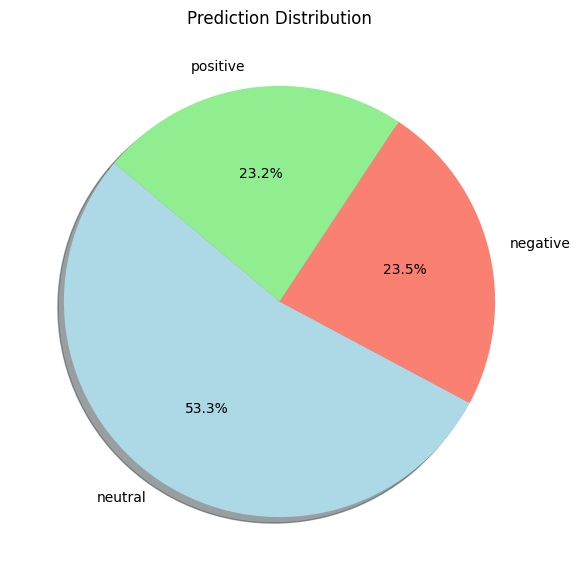

In [ ]:
print(df_filter["prediction"].value_counts())
counts = df_filter["prediction"].value_counts()
neutral_count = counts["neutral"]
negative_count = counts["negative"]
positive_count = counts["positive"]

import matplotlib.pyplot as plt
import numpy as np

# Pie Chart for Predictions
predictions = {'neutral': neutral_count, 'negative': negative_count, 'positive': positive_count}
labels = predictions.keys()
sizes = predictions.values()
colors = ['lightblue', 'salmon', 'lightgreen']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=True)
plt.title('Prediction Distribution')
plt.show()



In [ ]:
# Increase column width to display full sentences
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Now this will show the entire sentence:
df_filter.head()

In [ ]:
import re

def remove_all_timestamps(text):
    return re.sub(r"\[[^\]]*\]", "", text).strip()


df_filter["sentence"] = df_filter["sentence"].apply(remove_all_timestamps)

/var/folders/tn/pscmvcrx3l9f8b34vnkcj0zc0000gn/T/ipykernel_916/2774050533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter["sentence"] = df_filter["sentence"].apply(remove_all_timestamps)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance data (provided)
feature_importance = [ ('20sd_NVDA', 0.02246598919706179),
    ('ma7_NVDA', 0.01483291768658588), ('upper_band_NVDA', 0.0143196281629824), ('MACD_NVDA', 0.014289224440898165),
    ('ema_NVDA', 0.012550741495423448), ('rsi_', 0.01200165616884346), ('26ema_NVDA', 0.011072750065812303),
    ('Low_NVDA', 0.010961536903799609), ('High_NVDA', 0.010893214128390241), ('Open_NVDA', 0.009417759856917281),
    ('Close_NVDA', 0.007565295280411855), ('12ema_NVDA', 0.007025929934891378), ('ma21_NVDA', 0.004814125058877231),
    ('volatility_', 0.0038297832636159396), ('Volume_NVDA', 0.0036320043705808536), ('logit_negative', 0.0013811796078875285),
    ('lower_band_NVDA', 0.0010953724126540746), ('sentiment_score', 0.0003046146852058882), ('logit_neutral', 0.00026448941107205413),
    ('logit_positive', 0.00010371363981390071), ('change_label_', 7.557136261042453e-05)
]

# Sort features by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Unpack the sorted data
features, importance = zip(*feature_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
df_nvda = df[(df["sentence"].str.contains("Nvidia", case=False, na=False))]
df.head()

,sentence,title,date,sentiment_score,logit,prediction
0,\n[00:00:00.000 --> 00:00:02.980] You're lis...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,"Sun, 09 Mar 2025 01:00:00 -0000",-0.005459,[0.0334826 0.03894154 0.9275758 ],neutral
1,[00:00:02.980 --> 00:00:06.920] The consensu...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,"Sun, 09 Mar 2025 01:00:00 -0000",-0.022385,[0.03582151 0.0582066 0.90597194],neutral
2,[00:00:08.920 --> 00:00:13.480] But Adam Wil...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,"Sun, 09 Mar 2025 01:00:00 -0000",0.834461,[0.9058316 0.07137078 0.02279765],positive
3,[00:00:21.400 --> 00:00:23.880] So that gene...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,"Sun, 09 Mar 2025 01:00:00 -0000",-0.381062,[0.02585247 0.40691456 0.567233 ],neutral
4,"[00:00:23.880 --> 00:00:28.320] Today, Adam ...",TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,"Sun, 09 Mar 2025 01:00:00 -0000",0.134514,[0.14909787 0.0145835 0.8363187 ],neutral


In [ ]:
print(df_nvda["prediction"].value_counts())


prediction
neutral     94
positive     9
negative     3
Name: count, dtype: int64
